# Data Loading and embedding
In this notebook, we do
1. load toyzero raw window data
1. generate masks
1. patchify and embedding

**To-consider:**
1. mask generating probably should be combined with embedding

In [1]:
import numpy as np
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [3]:
%load_ext autoreload
%autoreload 2

from transformer import *

## Load paired Toyzero data and generate masks 
Since this dataset was originally the test dataset of cycleGAN and used exclusively for test purpose, in order to use it as both train and test data for this supervised training, we set the first $1000$ pair of images for training and the remaining for test.

In [4]:
def load_image_fnames(dirname):
    """
    load image fnames.
    If amax_dataset_size is not infinity and is less than all available images,
    return a random subset of max_dataset_size image fnames.
    """
    assert Path(dirname).exists(), f"{dirname} doesn't exist"
    image_fnames = np.array(sorted(list(Path(dirname).glob('*npz'))))
    return image_fnames


class ToyzeroAlignedDataset(Dataset):
    def __init__(
            self, 
            dataroot, *, 
            max_dataset_size, 
            serial_batches, 
            train
    ):
        super(ToyzeroAlignedDataset, self).__init__()

        self.serial_batches = serial_batches
        self.patch_size = patch_size

        dir_A = Path(dataroot)/f'testA'
        dir_B = Path(dataroot)/f'testB'
        self.image_fnames_A = load_image_fnames(dir_A)
        self.image_fnames_B = load_image_fnames(dir_B)
        
        if train:
            self.image_fnames_A = self.image_fnames_A[:1000]
            self.image_fnames_B = self.image_fnames_B[:1000]
        else:
            self.image_fnames_A = self.image_fnames_A[1000:]
            self.image_fnames_B = self.image_fnames_B[1000:]

        assert len(self.image_fnames_A) == len(self.image_fnames_B), "The dataset is not aligned"
        
        aligned = True
        for fname_A, fname_B in zip(self.image_fnames_A, self.image_fnames_B):
            if fname_A.stem != fname_B.stem:
                aligned = False
                break
        if not aligned:
            print("The dataset is not aligned")
            exit()

        self.size = len(self.image_fnames_A)

        if max_dataset_size != float('inf') and max_dataset_size < self.size:
            indices = np.arange(self.size)
            np.random.shuffle(indices)
            indices = indices[:max_dataset_size]
            self.image_fnames_A = self.image_fnames_A[indices]
            self.image_fnames_B = self.image_fnames_B[indices]
            self.size = max_dataset_size

    def __len__(self):
        return self.size

    def __load(self, image_fname):
        image = np.load(image_fname)
        image = image[image.files[0]]
        image = np.expand_dims(np.float32(image), 0)
        return image

    def __getitem__(self, index):
        if self.serial_batches:
            index = index % self.size
        else:
            index = np.random.randint(0, self.size - 1)
        
        image_A = self.__load(self.image_fnames_A[index])
        image_B = self.__load(self.image_fnames_B[index])

        
        return {
            'A': image_A, 
            'B': image_B, 
        }


## Patchify and depatchify

In [5]:
def patchify(x, patch_size):
    """
    Cut a batch of images into non-overlapping patches and stack them
    Input:
        - x (Tensor): The input tensor with shape (batch_size(N), n_channels(C), width(W), height(H));
        - patch_size (int): the side length of the patch, which means each patch is of size (patch_size, patch_size);
    Output:
        Tensor of shape (batch_size * num_patches, n_channel, patch_size, patch_size).
        The first 1 through num_patches belongs to the first image 
        and the num_patches + 1 through 2 * num_patches belongs to the second image, etc.
    """
    batch_size = x.size(0)
    image_size = x.size(-1)
    patches = [
        x[b, :, i: i + patch_size, j: j + patch_size].unsqueeze(0)
        for b in range(batch_size)
        for i in range(0, image_size, patch_size)
        for j in range(0, image_size, patch_size)
    ]
    return torch.cat(patches, dim=0)


def depatchify(x, batch_size):
    """
    Assemble the patches back to a image.
    NOTE: We assume that both the image and patch are square.
    Input:
        - x (Tensor): The input tensor with shape (batch_size * num_patches, n_channel, patch_size, patch_size)
        - batch_size (int): number of FULL images in a batch
    """
    patch_size = x.size(-1)
    # Number of patches per image
    num_patches = x.size(0) // batch_size
    # Number of patches along each edge
    num_patches_edge = int(np.sqrt(num_patches))
    
    patches = x.view(-1, num_patches, *x.shape[1:])
    images = []
    for I in patches:
        rows = []
        for i in range(num_patches_edge):
            start = i * num_patches_edge
            row = torch.cat([I[start + j] for j in range(num_patches_edge)], dim=-1)
            rows.append(row)
        image = torch.cat(rows, dim=-2)
        image = torch.unsqueeze(image, 0)
        images.append(image)
    return torch.cat(images, dim=0)


# ================================= Test  ================================= 
patch_size = 8
image_size = 24
batch_size = 2

x = np.random.randint(0, 10, size=(batch_size, 1, image_size, image_size))
x = torch.from_numpy(x)
p = patchify(x, patch_size)
print(p.shape)
y = depatchify(p, batch_size)
print(x == y)

torch.Size([18, 1, 8, 8])
tensor([[[[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]]],


        [[[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]]]])


## Embedding

In [6]:
class Embedding(nn.Module):
    def __init__(self, d_model, image_size, patch_size, mode='conv', leading=True, source=True):
        """
        Input:
            - d_model (int): the embedding dimension
            - image_size (int): We assume square images and image_size is the side length of the square
            - patch_size (int): We assume square patches and patch_size is the side length of the square
            - mode (str): choose one from ['plain', 'conv', 'fourier']
                - plain: normalization + linear (2 * d_model) + activation + normalization + linear (TO BE IMPLEMENTED)
                - conv: convolution
                - fourier: 2d-fourier embedding (TO BE IMPLEMENTED)
            - leading (bool): Whether there is a leading "token" indicating the start of a sequence
        """
        super(Embedding, self).__init__()
        self.d_model = d_model
        self.image_size = image_size
        self.patch_size = patch_size
        self.leading = leading
        self.source = source
        if not leading:
            self.source = False
        
        if mode == 'conv':
            num_patches = (image_size // patch_size) ** 2
            
            num_layers = self.get_exp(patch_size)
            if num_layers == -1:
                raise ValueError(f"patch_size ({patch_size}) is not a power of 2")
                
            num_channel_base = 2 ** (num_layers - 1)
            assert d_model % num_channel_base == 0, \
                f"d_model ({d_mode}) is not a multiple of ({num_channel_base})"
            
            conv_blocks = []
            in_channels = 1
            out_channels = d_model // num_channel_base
            for i in range(num_layers - 1):
                conv_blocks += [
                    nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1), 
                    nn.BatchNorm2d(out_channels), 
                    nn.ReLU(),
                    # nn.LeakyReLU(negative_slope=.2)
                ]
                in_channels = out_channels
                out_channels *= 2
            conv_blocks.append(nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1))
            self.layers = nn.ModuleList(conv_blocks)
        else:
            raise NotImplementedError(f"{mode} embedding is not implemented")
    
    @staticmethod
    def get_exp(num):
        exp = 0
        while num % 2 == 0:
            num, exp = num // 2, exp + 1
        return -1 if num != 1 else exp       
    
    def forward(self, x):
        batch_size = x.size(0)
        num_patches = (x.size(-1) // self.patch_size) ** 2
        
        assert all([s == self.image_size for s in x.shape[-2:]]), \
            f"image must have size ({self.image_size} x {self.image_size})."
        p = patchify(x, self.patch_size)
        for i, layer in enumerate(self.layers):
            p = layer(p)
            
        p = p.squeeze()
        
        # ADD ANNOTATION HERE
        tokenized_images = []
        for start in range(0, p.size(0), num_patches):
            tokenized_image = p[start: start + num_patches]
            if self.leading:
                # Now, the tokenized_image is of shape (seq_len, embedding_length), and
                # we need to add one row of ones as the top row.
                # The parameter 'pad' is in the order (left, right, top, bottom).
                tokenized_image = F.pad(tokenized_image, pad=(0, 0, 1, 0), mode='constant', value=1)
#                 if not self.source:
#                     tokenized_image = tokenized_image[:-1]
                # print(f'padded {tokenized_image}')
            tokenized_image = tokenized_image.unsqueeze(0)
            tokenized_images.append(tokenized_image)
        T = torch.cat(tokenized_images, dim=0)    
        return T * np.sqrt(self.d_model)

## Generator

In [7]:
class Generator(nn.Module):
    """
    Define standard linear + softmax generation step.
    """
    def __init__(self, d_model, image_size, patch_size, mode='conv', leading=True):
        """
        Input:
            - d_model (int): the embedding dimension
            - image_size (int): We assume square images and image_size is the side length of the square
            - patch_size (int): We assume square patches and patch_size is the side length of the square
            - mode (str): choose one from ['plain', 'conv', 'fourier']
                - plain: normalization + linear (2 * d_model) + activation + normalization + linear (TO BE IMPLEMENTED)
                - conv: convolution
                - fourier: 2d-fourier embedding (TO BE IMPLEMENTED)
            - leading (bool): Whether there is a leading "token" indicating the start of a sequence
        """
        super(Generator, self).__init__()
        self.d_model = d_model
        self.image_size = image_size
        self.patch_size = patch_size
        self.leading = leading
        if mode == 'conv':
            num_patches = (image_size // patch_size) ** 2
            
            num_layers = self.get_exp(patch_size)
            if num_layers == -1:
                raise ValueError(f"patch_size ({patch_size}) is not a power of 2")
                
            num_channel_base = 2 ** (num_layers - 1)
            assert d_model % num_channel_base == 0, \
                f"d_model ({d_mode}) is not a multiple of ({num_channel_base})"
            
            conv_blocks = []
            in_channels = d_model
            for i in range(num_layers - 1):
                out_channels = in_channels // 2
                conv_blocks += [
                    nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1), 
                    nn.BatchNorm2d(out_channels), 
                    nn.ReLU(),
                    # nn.LeakyReLU(negative_slope=.2)
                ]
                in_channels = out_channels
            conv_blocks.append(nn.ConvTranspose2d(in_channels, 1, kernel_size=4, stride=2, padding=1))
            self.layers = nn.ModuleList(conv_blocks)
        else:
            raise NotImplementedError(f"{mode} embedding is not implemented")
    
    @staticmethod
    def get_exp(num):
        exp = 0
        while num % 2 == 0:
            num, exp = num // 2, exp + 1
        return -1 if num != 1 else exp
    
    def forward(self, x):
        """
        Input:
            - x (Tensor): tensor of shape (batch_size, seq_len, d_model)
        """
        batch_size = x.size(0)
        
        # 1) Stack the embedded tokens from each sequence 
        #    and get a tensor of shape (batch_size x seq_len, d_model).
        if self.leading:
            x = torch.cat([tokenized_image[1:] for tokenized_image in x], dim=0)
        else:
            x = torch.cat([tokenized_image for tokenized_image in x], dim=0)
        # x = torch.cat([tokenized_image for tokenized_image in x], dim=0)
        # 2) Add width=1 and height=1 to the end of the tensor and 
        #    get a tensor of shape (batch_size x seq_len, d_model, 1, 1).
        x = x.unsqueeze(-1).unsqueeze(-1)
        # 3) Apply deconvolution, decrease the number of freatures
        #    while increasing the image size, so that the output
        #    has shape (batch_size x seq_len, 1, patch_size, patch_size).
        for i, layer in enumerate(self.layers):
            x = layer(x)
        # 4) Depatchify the patches back to images.
        #    The seq_len is the number of patches, which is a square.
        #    The number of patches along each side, P, is the square root of seq_len
        #    The resulting tensor is of size 
        #    (batch_size, 1, patch_size * P, patch_size * P), 
        #    where patch_size * P is the side length of the original image.
        x = depatchify(x, batch_size)
        return x

## Load Toyzero data and test the Embedding and Generator

In [8]:
# Set the device, either 'cuda' or 'cpu'
device = 'cuda'

# Load data
dataroot='/sdcc/u/yhuang2/PROJs/GAN/datasets/ls4gan/toyzero_cropped/toyzero_1001_300-128x128_U/'
max_dataset_size = 256
serial_batches = True
# batch_size = max_dataset_size
batch_size = 32

dataset = ToyzeroAlignedDataset(
    dataroot, 
    max_dataset_size=max_dataset_size, 
    serial_batches=serial_batches, 
    # patch_size=16
    train=True
)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=serial_batches)
data = next(iter(loader))

# Set parameter
image_size = 128
patch_size = 16
d_model = 512
leading = False

# Embedding
eb = Embedding(d_model, image_size, patch_size, mode='conv', leading=leading).to(device)
embedding = eb(data['A'].to(device))
print(embedding.shape)

# Generator
gr = Generator(d_model, image_size, patch_size, mode='conv').to(device)
images = gr(embedding)
print(images.shape)

torch.Size([32, 64, 512])
torch.Size([32, 1, 112, 112])


## Train a pure embedding-generator network WITHOUT attention in between

In [9]:
class Simple(nn.Module):
    def __init__(self, embedding, generator):
        super(Simple, self).__init__()
        self.embedding = embedding
        self.generator = generator
        
    def forward(self, x):
        embedded = self.embedding(x)
        return self.generator(embedded)

### A simple plotting function that shows input, output, and target

In [10]:
def SimplePlot(x, out, y, kwargs=None):
    
    num_samples = 5
    cmap = 'bwr'
    if kwargs:
        if num_samples in kwargs:
            num_samples = kwargs['num_samples']
        if cmap in kwargs:
            cmap = kwargs['cmap']
    
    total_samples = x.size(0)
    indices = np.random.choice(total_samples, num_samples, replace=False)
    images = torch.stack([x[indices], out[indices], y[indices]]).squeeze().transpose_(0, 1).detach().cpu().numpy()
    
    width = 4
    fig, axes = plt.subplots(num_samples, 3, figsize=(3 * width * 1.1, num_samples * width))
    for i, row in enumerate(axes):
        for j, ax in enumerate(row):
            image = images[i][j]
            vmin, vmax = image.min(), image.max()
            if vmin == 0:
                vmin = -.05
            if vmax == 0:
                vmax = .05
            divnorm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)
            ax.set_aspect(1)
            im = ax.pcolormesh(images[i][j], cmap=cmap, norm=divnorm)
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.1)
            fig.colorbar(im, cax=cax, orientation='vertical')
    plt.tight_layout()
    
    # block=False for immediate plotting. 
    # Otherwise, the plots will show all at once at the end.
    plt.show(block=False) 
    
# # ========================== Test ==========================
# x = torch.randn(10, 1, 128, 128)
# out = torch.randn(10, 1, 128, 128)
# y = torch.randn(10, 1, 128, 128)
# plot(x, out, y)

In [11]:
def run_epoch(batches, model, loss_compute, logging_freq=50, plot_func=None, plot_kwargs=None):
    """
    Standard training and logging function
    """    
    start = time.time()
    total_loss = 0 # cumulative loss
    total_image = 0

    for i, batch in enumerate(batches):
        x = batch['A'].to(device)
        out = model(x)
        y = batch['B'].to(device)
        loss = loss_compute(out, y)
        num_images = batch['A'].size(0)
        total_loss += loss * batch['A'].size(0)
        total_image += num_images

        if logging_freq > 0:
            if i % logging_freq == logging_freq - 1:
                elapsed = time.time() - start
                print(f'\tIteration: {i + 1}')
                print(f'\t\tCurrent loss per image:\t{loss / num_images:.6f}')
                print(f'\t\tAvg. time per batch:\t{elapsed / logging_freq:.6f}')
                start = time.time()
    if plot_func:
        if plot_kwargs:
            plot_func(x, out, y, plot_kwargs)
        else:
            plot_func(x, out, y) 
            
    return total_loss / total_image

In [12]:
class NoamOpt:
    """
    Optim wrapper that implements learning rate.
    """
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

        self._a = self.factor * (self.model_size ** -.5)
        self._b = self.warmup ** (-1.5)

    def step(self):
        """
        update parameters and rate
        """
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate

        self._rate = rate
        self.optimizer.step()

    def rate(self, step=None):
        """
        Implement lr as defined above.
        """
        if step is None:
            step = self._step
        return self._a * min(step ** (-.5), step * self._b)

In [13]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

class LossCompute:
    """
    A simple loss compute and train function.
    """
    def __init__(self, criterion, opt=None):
        self.criterion = criterion
        self.opt = opt
    
    def __call__(self, x, y):
        loss = self.criterion(x, y)
        
        if self.opt is not None:
            loss.backward()
            self.opt.step()
            self.opt.optimizer.zero_grad()
        
        return loss.item()

### Train

In [14]:
# Set parameter
dataroot='/sdcc/u/yhuang2/PROJs/GAN/datasets/ls4gan/toyzero_cropped/toyzero_1001_300-128x128_U/'
# Set the device, either 'cuda' or 'cpu'
device = 'cuda'
image_size = 128
patch_size = 16
d_model = 512
leading = False

# Load train data
max_dataset_size = 512
serial_batches = True
# batch_size = max_dataset_size
batch_size = 32

dataset = ToyzeroAlignedDataset(
    dataroot, 
    max_dataset_size=max_dataset_size, 
    serial_batches=serial_batches, 
    train=True
)
loader_train = DataLoader(dataset, batch_size=batch_size, shuffle=serial_batches)

# Load valid data
max_dataset_size = 512
serial_batches = True
batch_size = max_dataset_size
# batch_size = 32

dataset = ToyzeroAlignedDataset(
    dataroot, 
    max_dataset_size=max_dataset_size, 
    serial_batches=serial_batches, 
    train=False
)
loader_valid = DataLoader(dataset, batch_size=batch_size, shuffle=serial_batches)

checkpoint_folder = 'checkpoints/simple'
if not Path(checkpoint_folder).exists():
    Path(checkpoint_folder).mkdir(parents=True)
checkpoint_freq = 20

plot_freq = 20

# Transformer (Adding Attention)

### Make model

In [15]:
def make_model(
    image_size,
    patch_size, *,
    N=6,
    d_model=512,
    d_ff=2048,
    h=8,
    dropout=.1, 
    mode='conv',
    leading=True,
):
    """
    Construct a model from hyperparameters
    Input:
        - image_size (int): images are supposed to be square, and the image_size is the side length.
        - patch_size (int): patches are supposed to be square, and the patch_size is the side length.
        - N (int): number of encoder and decoder blocks.
        - d_model (int): d_model is the embedding length of each token. d_model must be divisible by h (number of heads).
        - d_ff (int): hidden units in the hidden layer of the feed-forward block.
        - h (int): number of heads in the multiheaded attention.
        - dropout (float): dropout rate used in many places in the network.
        - mode (string): way of embedding and generator.
        - leading (bool): whether to add a leading token to the embedded sequence (sequence of patches in our case).
    """

    C = copy.deepcopy

    attn = MultiHeadedAttention(h, d_model)
    ff = PositionWiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)

    encoder = Encoder(EncoderLayer(d_model, C(attn), C(ff), dropout), N)
    decoder = Decoder(DecoderLayer(d_model, C(attn), C(attn), C(ff), dropout), N)
    src_embedding = Embedding(d_model, image_size, patch_size, mode=mode, leading=leading, source=True)
    tgt_embedding = Embedding(d_model, image_size, patch_size, mode=mode, leading=leading, source=False)
    model = EncoderDecoder(
        encoder,
        decoder,
        nn.Sequential(src_embedding, C(position)),
        nn.Sequential(tgt_embedding, C(position)),
        Generator(d_model, image_size, patch_size, mode=mode)#, leading=leading)
    )

    # (author of this blog): This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

### Train

In [16]:
# run_epoch needs to be modified since the feed forward part also need 
def run_epoch(batches, model, loss_compute, logging_freq=50, plot_func=None, plot_kwargs=None):
    """
    Standard training and logging function
    """    
    start = time.time()
    total_loss = 0 # cumulative loss
    total_image = 0

    for i, batch in enumerate(batches):
        x = batch['A'].to(device)
        y = batch['B'].to(device)
        out = model(x, y) # run_epoch needs to be modified since the feed forward part also need 
        
        loss = loss_compute(out, y)
        num_images = batch['A'].size(0)
        total_loss += loss * batch['A'].size(0)
        total_image += num_images

        if logging_freq > 0:
            if i % logging_freq == logging_freq - 1:
                elapsed = time.time() - start
                print(f'\tIteration: {i + 1}')
                print(f'\t\tCurrent loss per image:\t{loss / num_images:.6f}')
                print(f'\t\tAvg. time per batch:\t{elapsed / logging_freq:.6f}')
                start = time.time()
    if plot_func:
        if plot_kwargs:
            plot_func(x, out, y, plot_kwargs)
        else:
            plot_func(x, out, y) 
            
    return total_loss / total_image

In [17]:
checkpoint_folder = 'checkpoints/transformer_full'
if not Path(checkpoint_folder).exists():
    Path(checkpoint_folder).mkdir(parents=True)

number of parameters = 10.25M
Epoch 1 / 200
	lr:		0.000000 -> 0.007906
	time per epoch:	5.648233 seconds
	train loss:	1.205066
	valid loss:	1.377454
	peak memory use:	27.372G
Epoch 2 / 200
	lr:		0.007906 -> 0.007813
	time per epoch:	5.496095 seconds
	train loss:	1.118435
	valid loss:	1.358681
	peak memory use:	27.372G
Epoch 3 / 200
	lr:		0.007813 -> 0.006379
	time per epoch:	5.536418 seconds
	train loss:	1.104702
	valid loss:	1.347613
	peak memory use:	27.372G
Epoch 4 / 200
	lr:		0.006379 -> 0.005524
	time per epoch:	5.554099 seconds
	train loss:	1.095102
	valid loss:	1.336404
	peak memory use:	27.372G
Epoch 5 / 200
	lr:		0.005524 -> 0.004941
	time per epoch:	5.495509 seconds
	train loss:	1.088620
	valid loss:	1.327386
	peak memory use:	27.372G
Epoch 6 / 200
	lr:		0.004941 -> 0.004511
	time per epoch:	5.499469 seconds
	train loss:	1.085350
	valid loss:	1.328509
	peak memory use:	27.372G
Epoch 7 / 200
	lr:		0.004511 -> 0.004176
	time per epoch:	5.555603 seconds
	train loss:	1.082517
	va

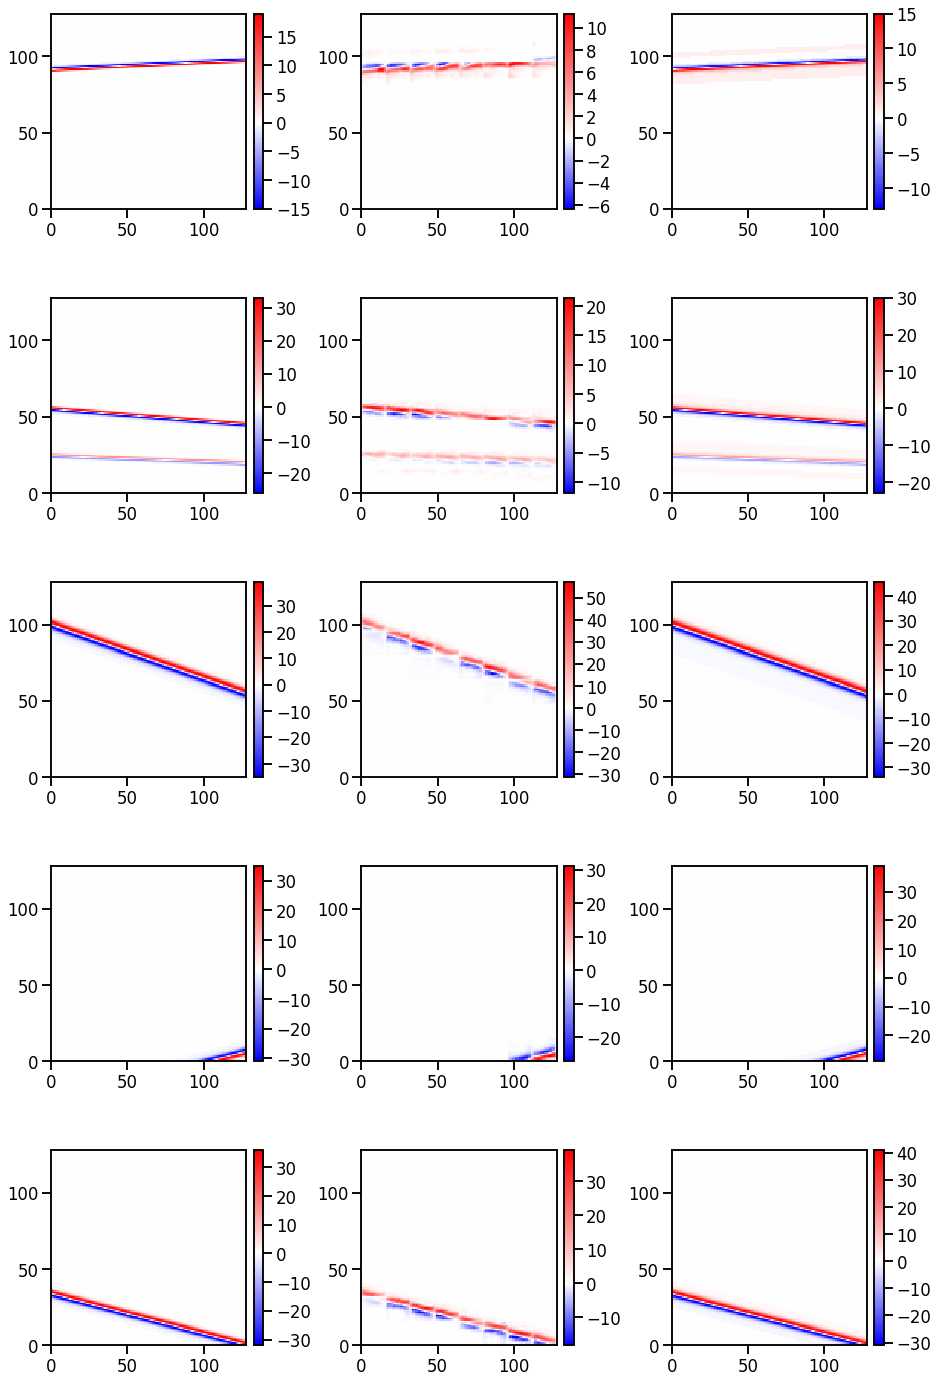

	valid loss:	0.729700
	Saving checkpoint
	peak memory use:	27.372G
Epoch 21 / 200
	lr:		0.002471 -> 0.002411
	time per epoch:	5.503553 seconds
	train loss:	0.611573
	valid loss:	0.696735
	peak memory use:	27.372G
Epoch 22 / 200
	lr:		0.002411 -> 0.002356
	time per epoch:	5.531329 seconds
	train loss:	0.573045
	valid loss:	0.720404
	peak memory use:	27.372G
Epoch 23 / 200
	lr:		0.002356 -> 0.002304
	time per epoch:	5.515936 seconds
	train loss:	0.541384
	valid loss:	0.660075
	peak memory use:	27.372G
Epoch 24 / 200
	lr:		0.002304 -> 0.002255
	time per epoch:	5.519671 seconds
	train loss:	0.513179
	valid loss:	0.604578
	peak memory use:	27.372G
Epoch 25 / 200
	lr:		0.002255 -> 0.002210
	time per epoch:	5.495935 seconds
	train loss:	0.495555
	valid loss:	0.625510
	peak memory use:	27.372G
Epoch 26 / 200
	lr:		0.002210 -> 0.002167
	time per epoch:	5.555751 seconds
	train loss:	0.459537
	valid loss:	0.562077
	peak memory use:	27.372G
Epoch 27 / 200
	lr:		0.002167 -> 0.002126
	time per epoch

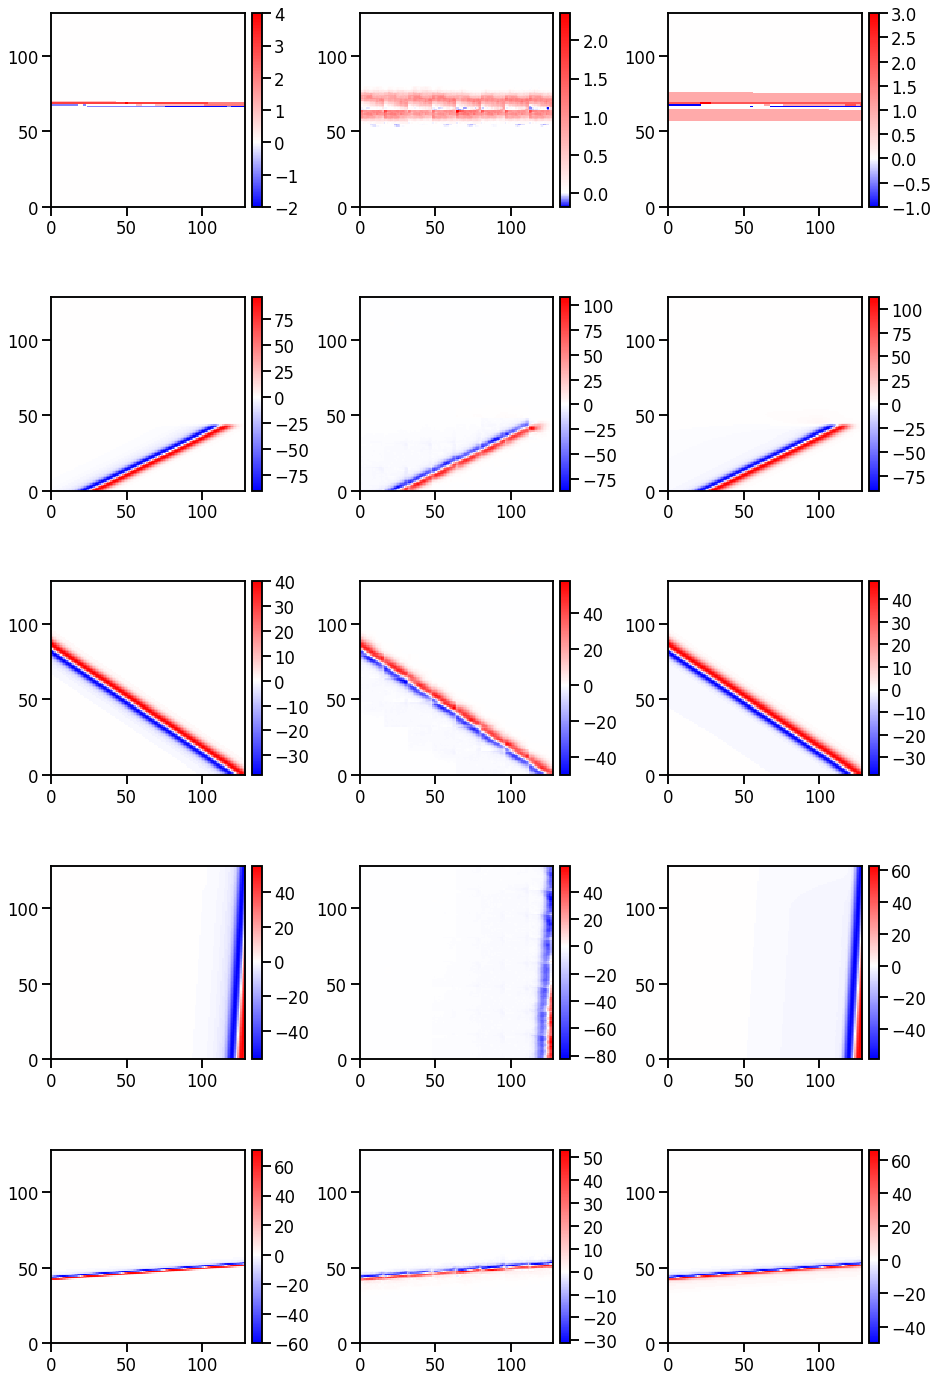

	valid loss:	0.399493
	Saving checkpoint
	peak memory use:	27.372G
Epoch 41 / 200
	lr:		0.001747 -> 0.001725
	time per epoch:	5.511209 seconds
	train loss:	0.343158
	valid loss:	0.449754
	peak memory use:	27.372G
Epoch 42 / 200
	lr:		0.001725 -> 0.001705
	time per epoch:	5.519047 seconds
	train loss:	0.326816
	valid loss:	0.382065
	peak memory use:	27.372G
Epoch 43 / 200
	lr:		0.001705 -> 0.001685
	time per epoch:	5.552902 seconds
	train loss:	0.320732
	valid loss:	0.363891
	peak memory use:	27.372G
Epoch 44 / 200
	lr:		0.001685 -> 0.001666
	time per epoch:	5.628105 seconds
	train loss:	0.331931
	valid loss:	0.373156
	peak memory use:	27.372G
Epoch 45 / 200
	lr:		0.001666 -> 0.001647
	time per epoch:	5.556214 seconds
	train loss:	0.307412
	valid loss:	0.356245
	peak memory use:	27.372G
Epoch 46 / 200
	lr:		0.001647 -> 0.001629
	time per epoch:	5.517640 seconds
	train loss:	0.298874
	valid loss:	0.371658
	peak memory use:	27.372G
Epoch 47 / 200
	lr:		0.001629 -> 0.001612
	time per epoch

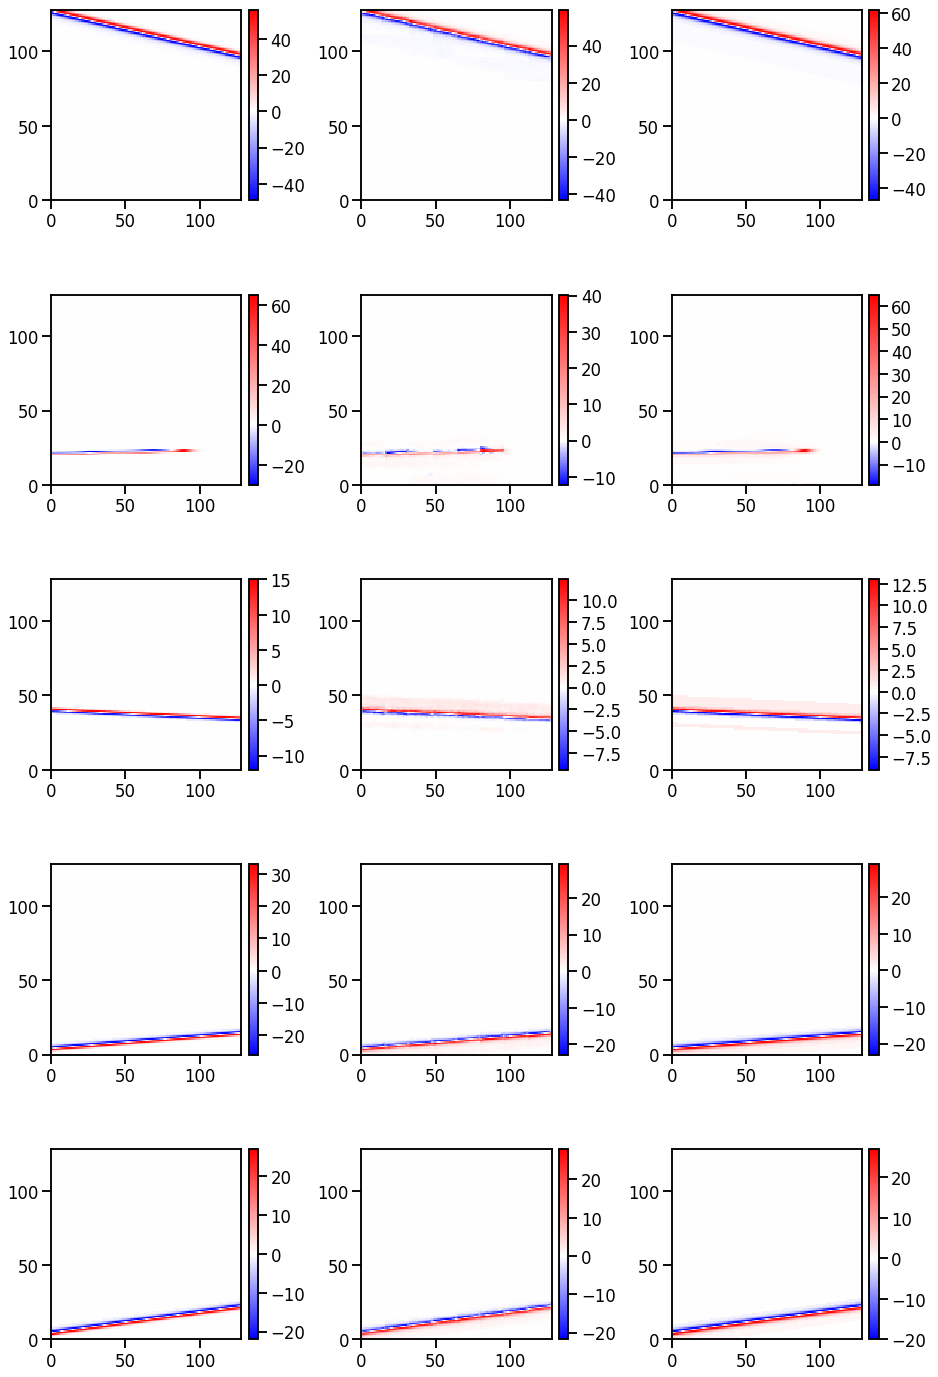

	valid loss:	0.364398
	Saving checkpoint
	peak memory use:	27.372G
Epoch 61 / 200
	lr:		0.001426 -> 0.001415
	time per epoch:	5.579605 seconds
	train loss:	0.262297
	valid loss:	0.328678
	peak memory use:	27.372G
Epoch 62 / 200
	lr:		0.001415 -> 0.001403
	time per epoch:	5.662579 seconds
	train loss:	0.277885
	valid loss:	0.324032
	peak memory use:	27.372G
Epoch 63 / 200
	lr:		0.001403 -> 0.001392
	time per epoch:	5.503647 seconds
	train loss:	0.254524
	valid loss:	0.297192
	peak memory use:	27.372G
Epoch 64 / 200
	lr:		0.001392 -> 0.001381
	time per epoch:	5.511534 seconds
	train loss:	0.254384
	valid loss:	0.314465
	peak memory use:	27.372G
Epoch 65 / 200
	lr:		0.001381 -> 0.001370
	time per epoch:	5.509859 seconds
	train loss:	0.251710
	valid loss:	0.302397
	peak memory use:	27.372G
Epoch 66 / 200
	lr:		0.001370 -> 0.001360
	time per epoch:	5.555352 seconds
	train loss:	0.277498
	valid loss:	0.296815
	peak memory use:	27.372G
Epoch 67 / 200
	lr:		0.001360 -> 0.001350
	time per epoch

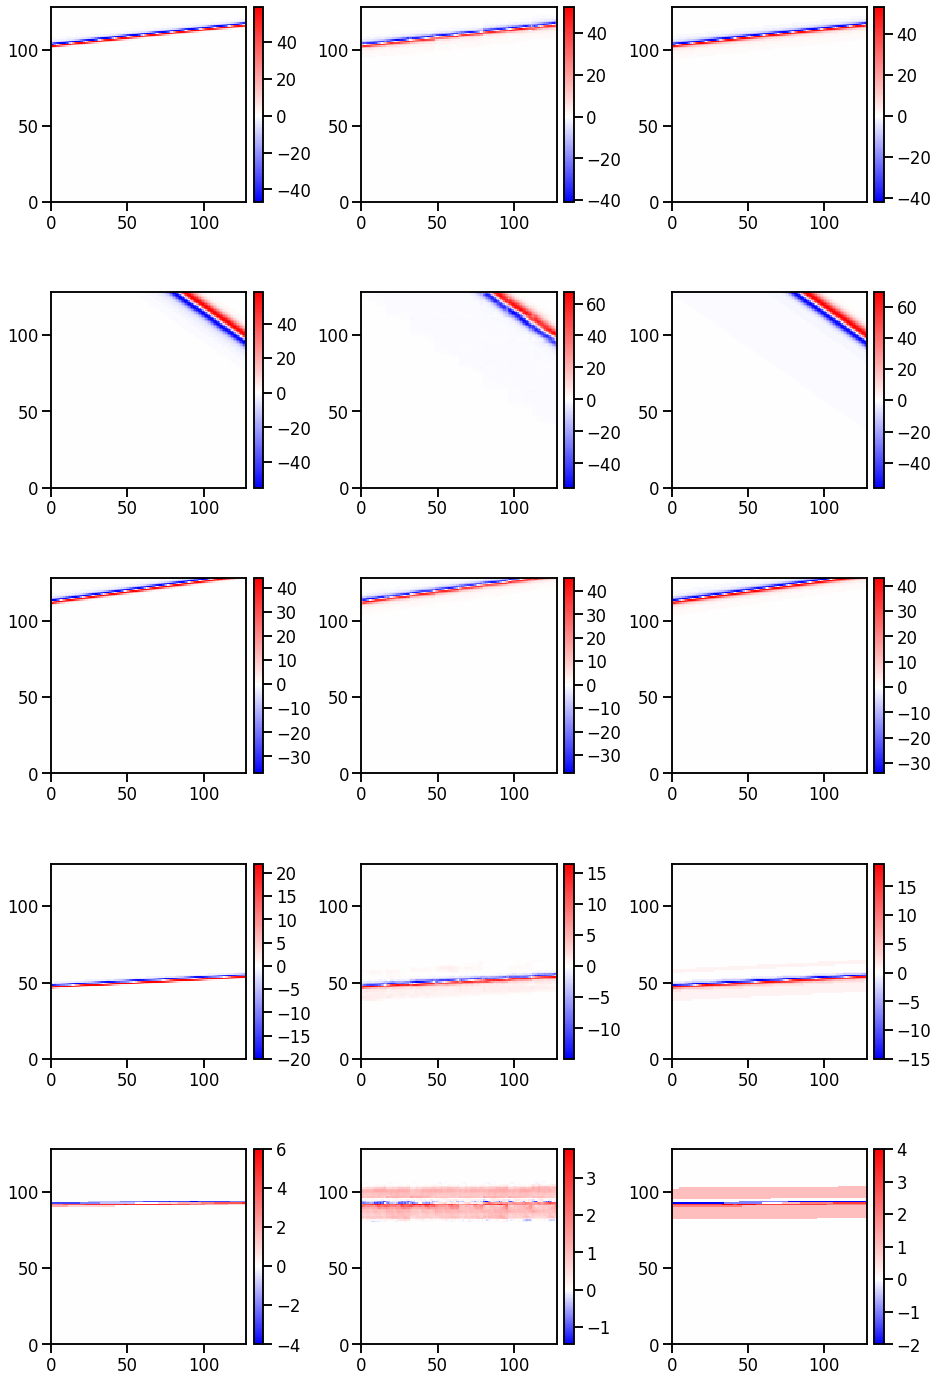

	valid loss:	0.287843
	Saving checkpoint
	peak memory use:	27.372G
Epoch 81 / 200
	lr:		0.001235 -> 0.001228
	time per epoch:	5.539224 seconds
	train loss:	0.261226
	valid loss:	0.348919
	peak memory use:	27.372G
Epoch 82 / 200
	lr:		0.001228 -> 0.001220
	time per epoch:	5.511406 seconds
	train loss:	0.250229
	valid loss:	0.320686
	peak memory use:	27.372G
Epoch 83 / 200
	lr:		0.001220 -> 0.001213
	time per epoch:	5.505875 seconds
	train loss:	0.229876
	valid loss:	0.270058
	peak memory use:	27.372G
Epoch 84 / 200
	lr:		0.001213 -> 0.001205
	time per epoch:	5.563029 seconds
	train loss:	0.215668
	valid loss:	0.270700
	peak memory use:	27.372G
Epoch 85 / 200
	lr:		0.001205 -> 0.001198
	time per epoch:	5.531290 seconds
	train loss:	0.246677
	valid loss:	0.273090
	peak memory use:	27.372G
Epoch 86 / 200
	lr:		0.001198 -> 0.001191
	time per epoch:	5.544683 seconds
	train loss:	0.237801
	valid loss:	0.297867
	peak memory use:	27.372G
Epoch 87 / 200
	lr:		0.001191 -> 0.001185
	time per epoch

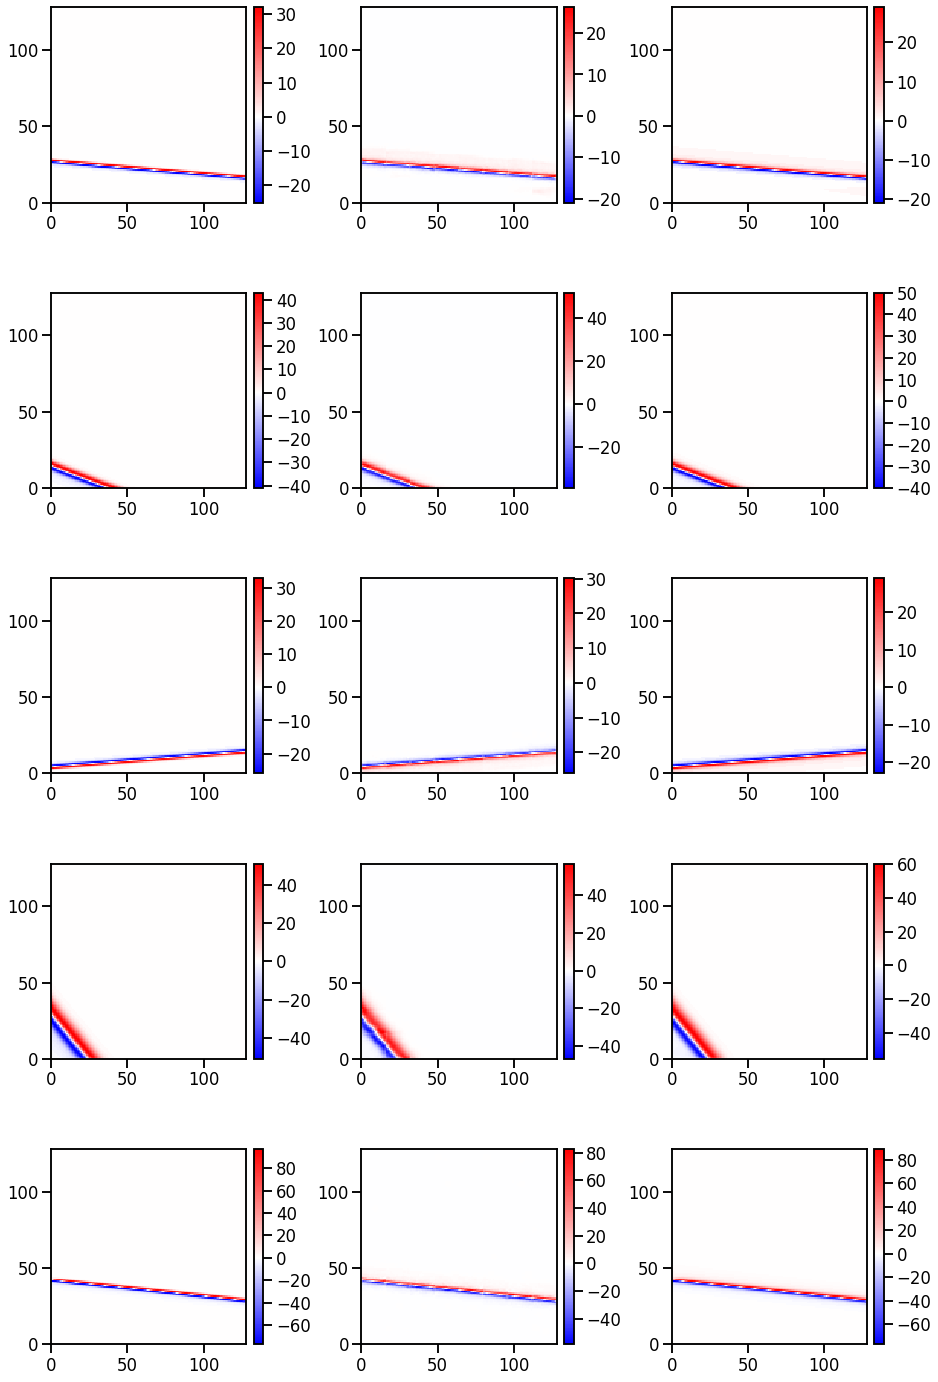

	valid loss:	0.307216
	Saving checkpoint
	peak memory use:	27.372G
Epoch 101 / 200
	lr:		0.001105 -> 0.001099
	time per epoch:	5.535700 seconds
	train loss:	0.221168
	valid loss:	0.250950
	peak memory use:	27.372G
Epoch 102 / 200
	lr:		0.001099 -> 0.001094
	time per epoch:	5.515413 seconds
	train loss:	0.237932
	valid loss:	0.289264
	peak memory use:	27.372G
Epoch 103 / 200
	lr:		0.001094 -> 0.001089
	time per epoch:	5.522310 seconds
	train loss:	0.236540
	valid loss:	0.282104
	peak memory use:	27.372G
Epoch 104 / 200
	lr:		0.001089 -> 0.001083
	time per epoch:	5.589571 seconds
	train loss:	0.221491
	valid loss:	0.254924
	peak memory use:	27.372G
Epoch 105 / 200
	lr:		0.001083 -> 0.001078
	time per epoch:	5.545108 seconds
	train loss:	0.209243
	valid loss:	0.288039
	peak memory use:	27.372G
Epoch 106 / 200
	lr:		0.001078 -> 0.001073
	time per epoch:	5.515398 seconds
	train loss:	0.207733
	valid loss:	0.246166
	peak memory use:	27.372G
Epoch 107 / 200
	lr:		0.001073 -> 0.001068
	time pe

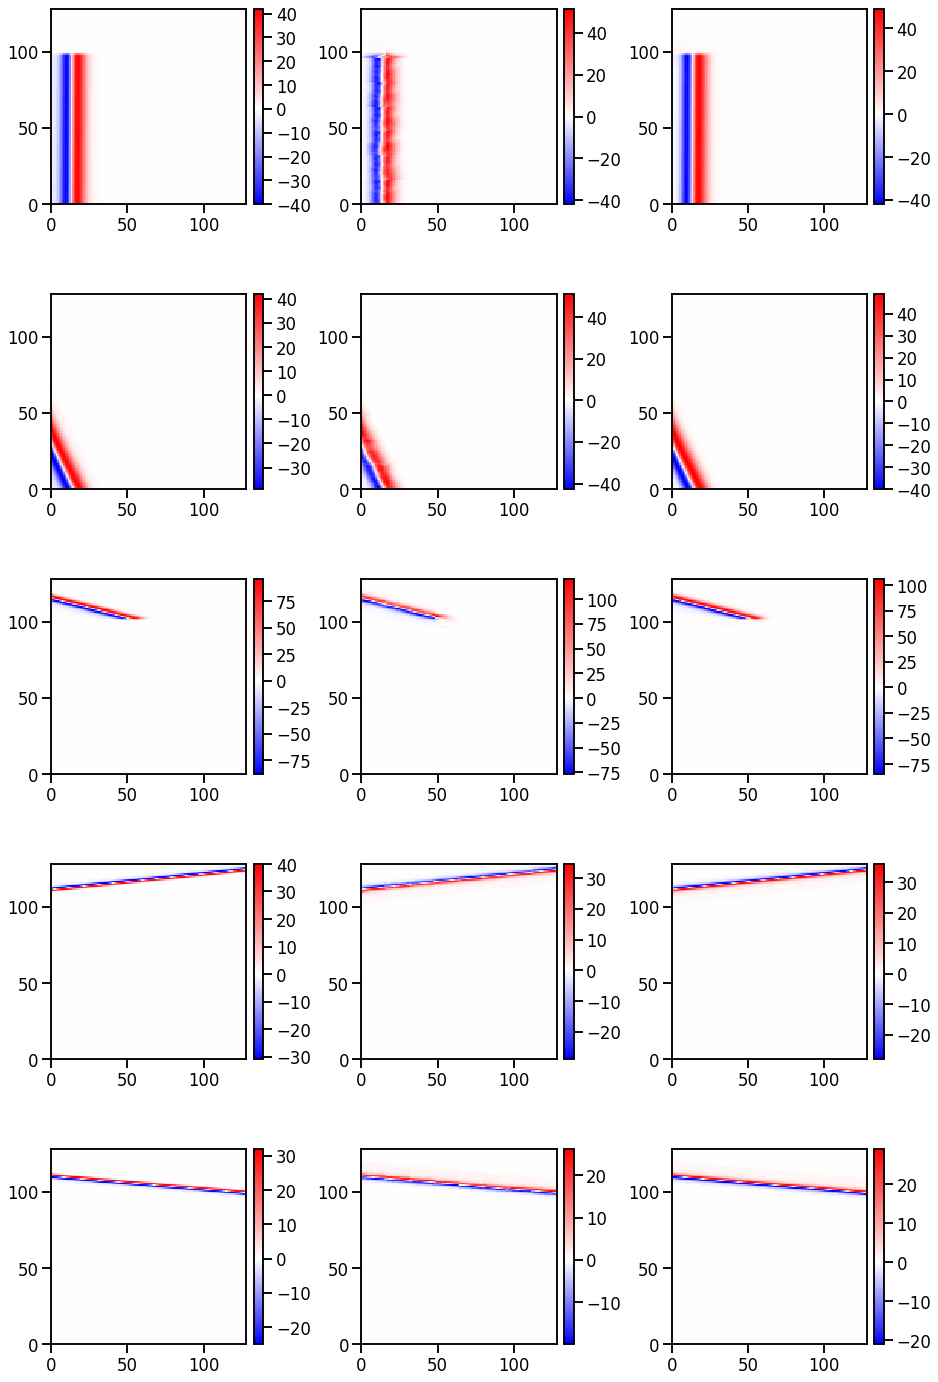

	valid loss:	0.288807
	Saving checkpoint
	peak memory use:	27.372G
Epoch 121 / 200
	lr:		0.001009 -> 0.001004
	time per epoch:	5.561399 seconds
	train loss:	0.216488
	valid loss:	0.263718
	peak memory use:	27.372G
Epoch 122 / 200
	lr:		0.001004 -> 0.001000
	time per epoch:	5.628677 seconds
	train loss:	0.212313
	valid loss:	0.248900
	peak memory use:	27.372G
Epoch 123 / 200
	lr:		0.001000 -> 0.000996
	time per epoch:	5.525215 seconds
	train loss:	0.207647
	valid loss:	0.332997
	peak memory use:	27.372G
Epoch 124 / 200
	lr:		0.000996 -> 0.000992
	time per epoch:	5.514109 seconds
	train loss:	0.213546
	valid loss:	0.253516
	peak memory use:	27.372G
Epoch 125 / 200
	lr:		0.000992 -> 0.000988
	time per epoch:	5.503615 seconds
	train loss:	0.206508
	valid loss:	0.283301
	peak memory use:	27.372G
Epoch 126 / 200
	lr:		0.000988 -> 0.000984
	time per epoch:	5.589541 seconds
	train loss:	0.220128
	valid loss:	0.246783
	peak memory use:	27.372G
Epoch 127 / 200
	lr:		0.000984 -> 0.000980
	time pe

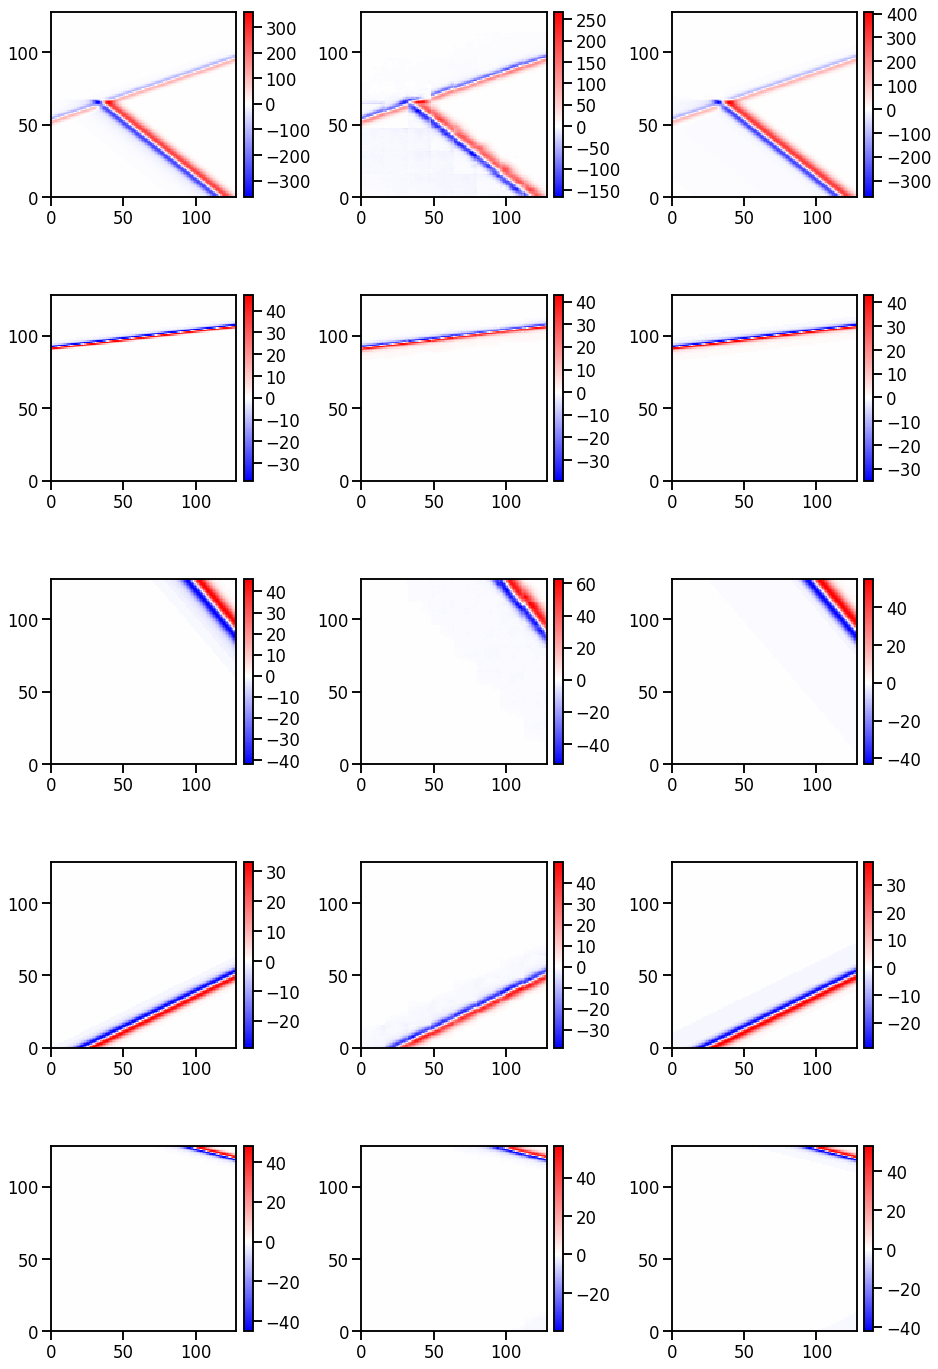

	valid loss:	0.254696
	Saving checkpoint
	peak memory use:	27.372G
Epoch 141 / 200
	lr:		0.000934 -> 0.000930
	time per epoch:	5.529886 seconds
	train loss:	0.206968
	valid loss:	0.243213
	peak memory use:	27.372G
Epoch 142 / 200
	lr:		0.000930 -> 0.000927
	time per epoch:	5.497097 seconds
	train loss:	0.193447
	valid loss:	0.275631
	peak memory use:	27.372G
Epoch 143 / 200
	lr:		0.000927 -> 0.000924
	time per epoch:	5.525431 seconds
	train loss:	0.199909
	valid loss:	0.295383
	peak memory use:	27.372G
Epoch 144 / 200
	lr:		0.000924 -> 0.000921
	time per epoch:	5.581789 seconds
	train loss:	0.189008
	valid loss:	0.273659
	peak memory use:	27.372G
Epoch 145 / 200
	lr:		0.000921 -> 0.000918
	time per epoch:	5.522755 seconds
	train loss:	0.196291
	valid loss:	0.235687
	peak memory use:	27.372G
Epoch 146 / 200
	lr:		0.000918 -> 0.000914
	time per epoch:	5.534511 seconds
	train loss:	0.197482
	valid loss:	0.272683
	peak memory use:	27.372G
Epoch 147 / 200
	lr:		0.000914 -> 0.000911
	time pe

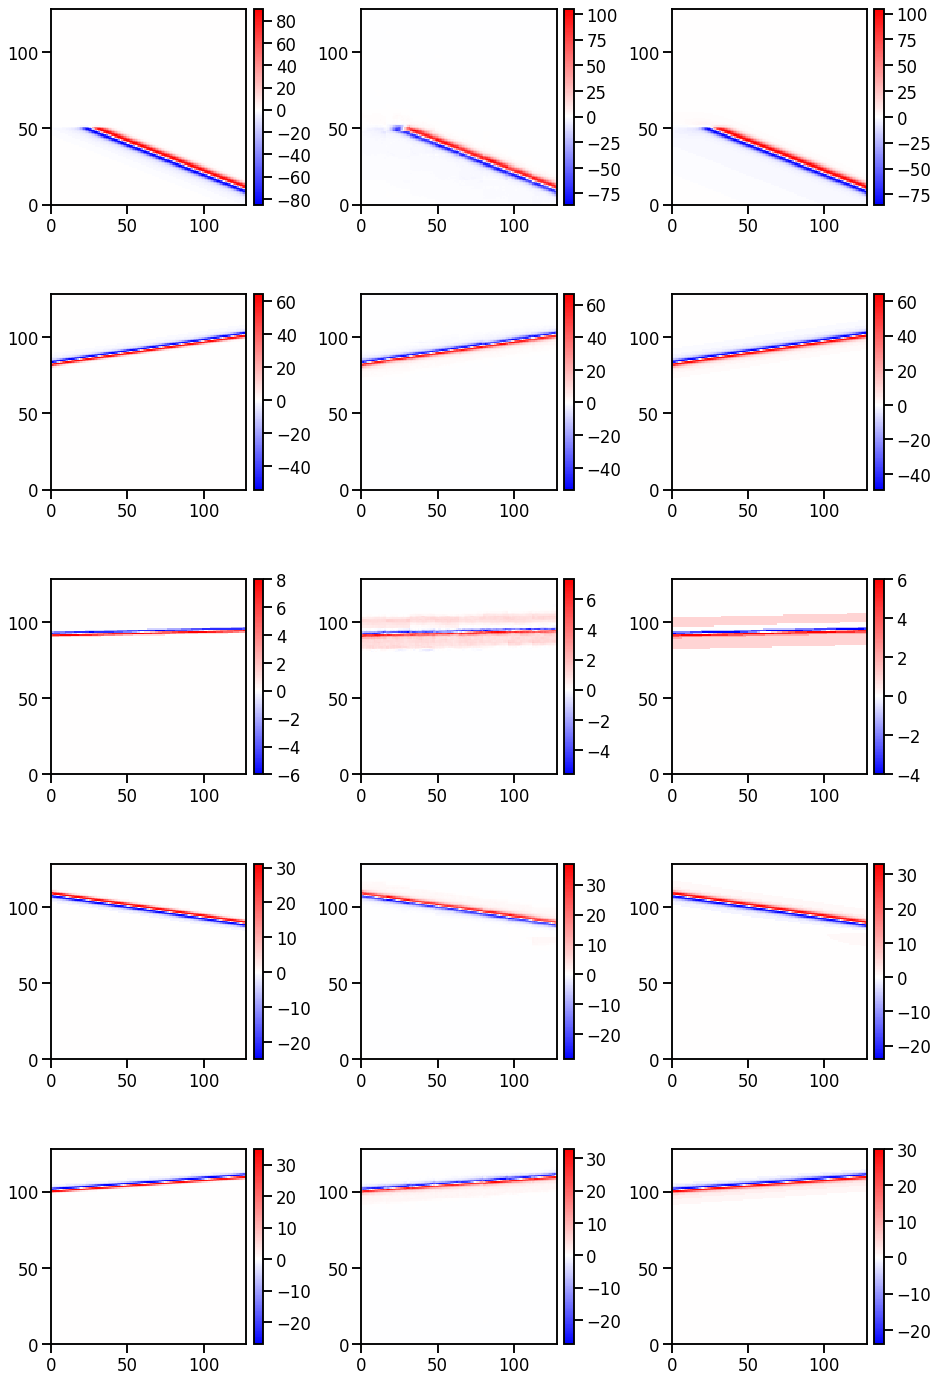

	valid loss:	0.238390
	Saving checkpoint
	peak memory use:	27.372G
Epoch 161 / 200
	lr:		0.000873 -> 0.000871
	time per epoch:	5.536314 seconds
	train loss:	0.187670
	valid loss:	0.275032
	peak memory use:	27.372G
Epoch 162 / 200
	lr:		0.000871 -> 0.000868
	time per epoch:	5.584152 seconds
	train loss:	0.194314
	valid loss:	0.271124
	peak memory use:	27.372G
Epoch 163 / 200
	lr:		0.000868 -> 0.000865
	time per epoch:	5.525438 seconds
	train loss:	0.202506
	valid loss:	0.251985
	peak memory use:	27.372G
Epoch 164 / 200
	lr:		0.000865 -> 0.000863
	time per epoch:	5.587198 seconds
	train loss:	0.188310
	valid loss:	0.296597
	peak memory use:	27.372G
Epoch 165 / 200
	lr:		0.000863 -> 0.000860
	time per epoch:	5.553729 seconds
	train loss:	0.218731
	valid loss:	0.251336
	peak memory use:	27.372G
Epoch 166 / 200
	lr:		0.000860 -> 0.000858
	time per epoch:	5.539088 seconds
	train loss:	0.216521
	valid loss:	0.256357
	peak memory use:	27.372G
Epoch 167 / 200
	lr:		0.000858 -> 0.000855
	time pe

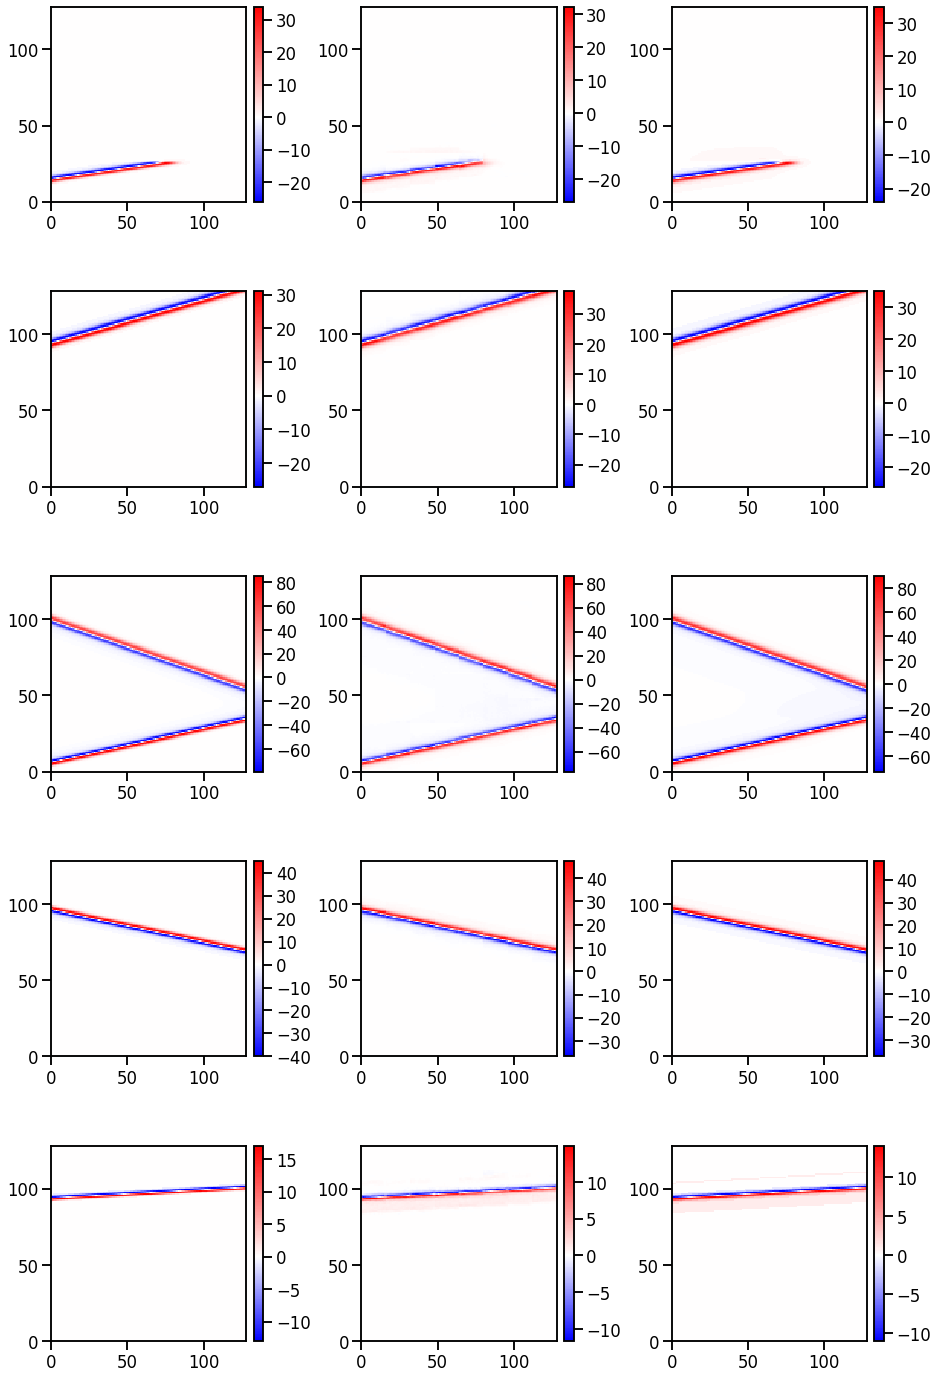

	valid loss:	0.262930
	Saving checkpoint
	peak memory use:	27.372G
Epoch 181 / 200
	lr:		0.000824 -> 0.000821
	time per epoch:	5.568263 seconds
	train loss:	0.176816
	valid loss:	0.245136
	peak memory use:	27.372G
Epoch 182 / 200
	lr:		0.000821 -> 0.000819
	time per epoch:	5.666766 seconds
	train loss:	0.180901
	valid loss:	0.297267
	peak memory use:	27.372G
Epoch 183 / 200
	lr:		0.000819 -> 0.000817
	time per epoch:	5.548288 seconds
	train loss:	0.186652
	valid loss:	0.258643
	peak memory use:	27.372G
Epoch 184 / 200
	lr:		0.000817 -> 0.000815
	time per epoch:	5.531506 seconds
	train loss:	0.189013
	valid loss:	0.256360
	peak memory use:	27.372G
Epoch 185 / 200
	lr:		0.000815 -> 0.000812
	time per epoch:	5.510102 seconds
	train loss:	0.184960
	valid loss:	0.258575
	peak memory use:	27.372G
Epoch 186 / 200
	lr:		0.000812 -> 0.000810
	time per epoch:	5.567909 seconds
	train loss:	0.184488
	valid loss:	0.246434
	peak memory use:	27.372G
Epoch 187 / 200
	lr:		0.000810 -> 0.000808
	time pe

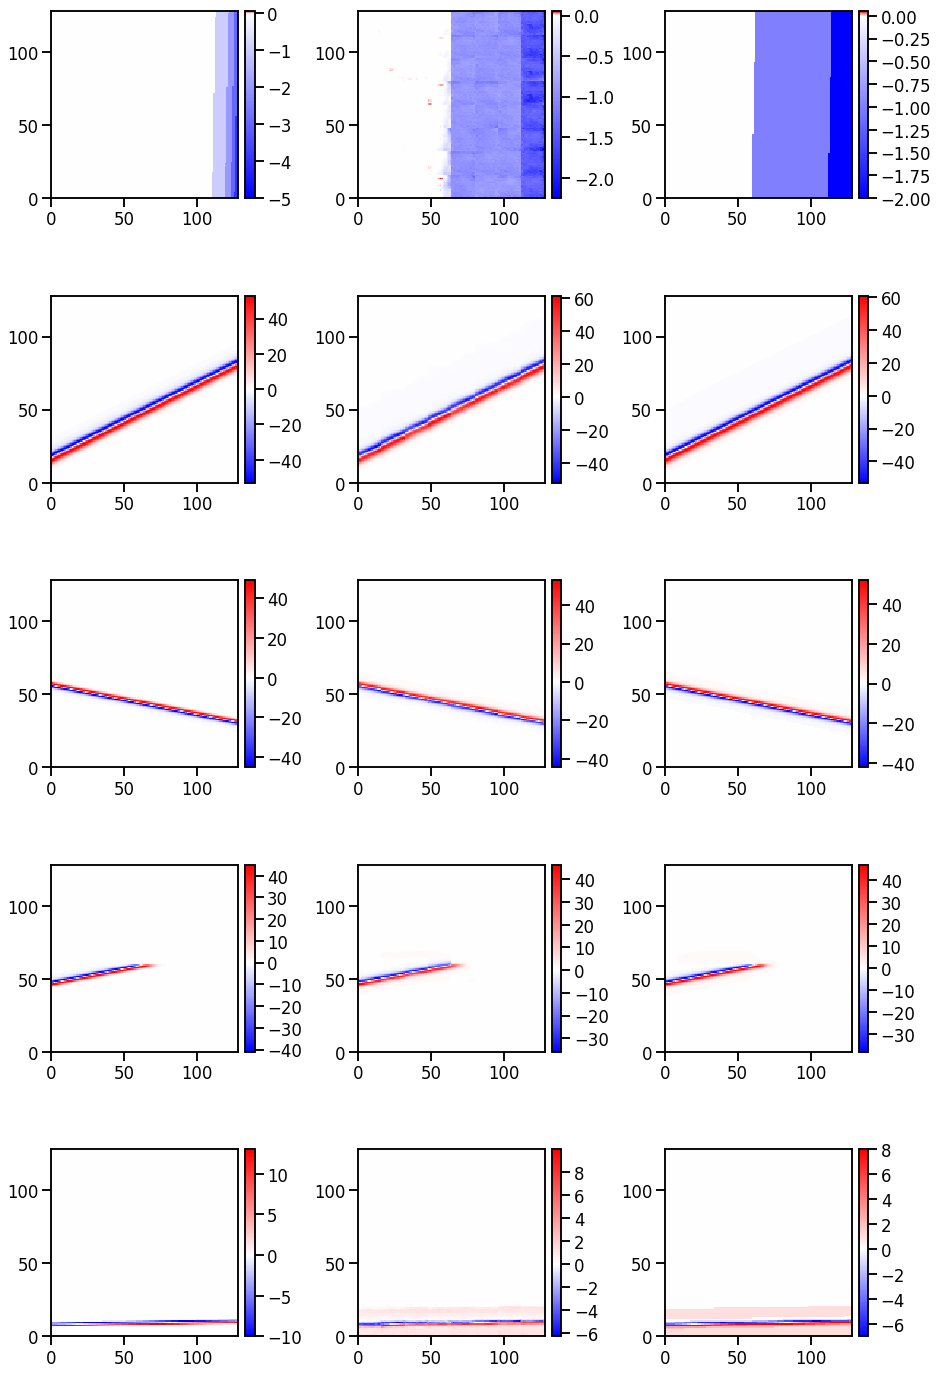

	valid loss:	0.244637
	Saving checkpoint
	peak memory use:	27.372G


In [18]:
model = make_model(image_size, patch_size, N=3, d_model=256).to(device)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'number of parameters = {num_params/1024**2:.2f}M')

model_opt = NoamOpt(
    d_model,
    1, # factor
    20, # warmup
    torch.optim.Adam(model.parameters(), lr=0, betas=(.9, .98), eps=1e-9)
)

epochs = 200
for epoch in range(epochs):
    print(f'Epoch {epoch + 1} / {epochs}')
    # tells your model that you are training the model. 
    # So effectively layers like dropout, batchnorm etc. 
    # which behave different on the train and test procedures 
    # know what is going on and hence can behave accordingly.
    model.train()
    start = time.time()
    old_lr = get_lr(model_opt.optimizer)
    loss_train = run_epoch(
        loader_train,
        model,
        LossCompute(nn.L1Loss(), model_opt),
        logging_freq=-1
    )
    new_lr = get_lr(model_opt.optimizer)
    print(f'\tlr:\t\t{old_lr:.6f} -> {new_lr:.6f}')
    print(f'\ttime per epoch:\t{time.time() - start:.6f} seconds')
    print(f'\ttrain loss:\t{loss_train:.6f}')
    
    # Validation:
    if epoch % plot_freq == plot_freq - 1:
        plot_func = SimplePlot
    else:
        plot_func = None
    
    loss_valid = run_epoch(
        loader_valid,
        model,
        LossCompute(nn.L1Loss()), # don't use an optimizer and the loss won't be back propagated
        logging_freq=-1, 
        plot_func=plot_func,
        plot_kwargs={'num_samples': 3}
    )
    print(f'\tvalid loss:\t{loss_valid:.6f}')
    
    if epoch % checkpoint_freq == checkpoint_freq - 1:
        print('\tSaving checkpoint')
        fname = f'model_dict_{epoch + 1}'
        torch.save(model.state_dict(), f'{checkpoint_folder}/{fname}.pt')
        torch.save(model.state_dict(), f'{checkpoint_folder}/model_dict_last.pt')
        
    memory_cuda = torch.cuda.max_memory_allocated(device='cuda')
    print(f'\tpeak memory use:\t{memory_cuda/1024 ** 3:.3f}G')